# Clasificación con modelos lineales en Python
En este taller vamos a tener una vista general de como hacer una clasificación lineal en Python, principalmente utilizando las librerias de Pandas, scitkit-learn y statsmodels. El objetivo es entender el proceso tipico sin profundizar demasiado en los distintos pasos.

In [1]:
import statsmodels.api as sm
import pandas as pd 
import plotnine as pn
import sklearn
import numpy as np


data_location = 'tweet_and_user_data.csv'

pd.options.display.max_columns = 500

## Los datos
Echamos un vistazo rapido a los datos que vamos a utilizar

In [2]:
tweet_data = pd.read_csv(data_location)

/Users/andreas/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
tweet_data.shape

(40581, 56)

In [4]:
tweet_data.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,id_user,name_user,username_user,bio,url,join_datetime,join_date,join_time,tweets,location,following,followers,likes,media,private,verified,avatar,background_image
0,1425590913959612419,1425590913959612419,1.628722e+12,2021-08-12 00:52:14,200,NaN,RT @girlsalliance: We're so proud of the four ...,en,[],[],409486555,409486555,MichelleObama,Michelle Obama,4,0,https://twitter.com/MichelleObama/status/14255...,[],[],0,NaN,True,0,0,232,0,None,NaN,NaN,NaN,1.047165e+18,We're so proud of the four organizations in ou...,1.425590e+18,[],2021-08-12 00:46:58 CEST,NaN,NaN,NaN,409486555,Michelle Obama,MichelleObama,Girl from the South Side and former First Lady...,https://t.co/HPYP9ad13Y,2011-11-10 20:13:01 UTC,2011-11-10,20:13:01 UTC,1770,"Washington, DC",16,20854298,184,461,False,True,https://pbs.twimg.com/profile_images/136674780...,https://pbs.twimg.com/profile_banners/40948655...
1,1427736867739299841,1427736867739299841,1.629234e+12,2021-08-17 22:59:29,200,NaN,Some casual suggestions to 😏SLIDE😏 into when u...,en,"['shoesdaytuesday', 'afterskewlslide']",[],21447363,21447363,katyperry,KATY PERRY,2,22,https://twitter.com/katyperry/status/142773686...,[],['https://pbs.twimg.com/media/E9BXG4YVkAAl3_A....,1,https://pbs.twimg.com/media/E9BXG4YVkAAl3_A.jpg,False,5266,368,408,0,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
2,1427667300488937476,1427667300488937476,1.629217e+12,2021-08-17 18:23:03,200,NaN,RT @ValaAfshar: You are not your job.,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,18,https://twitter.com/katyperry/status/142766730...,[],[],0,NaN,True,0,0,764,0,None,NaN,NaN,NaN,2.597252e+08,You are not your job.,1.427648e+18,[],2021-08-17 17:05:53 CEST,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
3,1427667012105371652,1427667012105371652,1.629217e+12,2021-08-17 18:21:55,200,NaN,What have we become 😔😂 Toddler Cites Freedom ...,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,18,https://twitter.com/katyperry/status/142766701...,['https://www.theonion.com/toddler-cites-freed...,[],0,NaN,False,5638,476,438,0,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
4,1427497703596990467,1427497703596990467,1.629177e+12,2021-08-17 07:09:08,200,NaN,The tech giants that refuse to massively addre...,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,7,https://twitter.com/katyperry/status/142749770...,[],[],0,NaN,False,8810,546,1211,https://twitter.com/VICENews/status/1427311204...,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...


## Nuestra prediccion
Miramos nuestro target y las variables que pueden ser importantes, finalizando con el train-test split

In [5]:
tweet_data.nlikes.quantile([0.5, 0.75, 0.9, 0.95, 0.99])

0.50       39.0
0.75      198.0
0.90     1318.0
0.95     4319.0
0.99    25868.0
Name: nlikes, dtype: float64

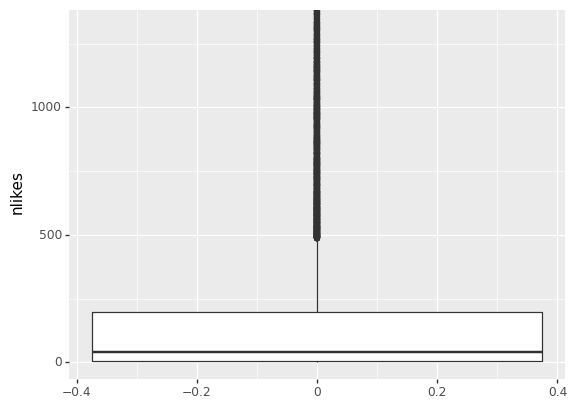

In [6]:
graph = (
    pn.ggplot(tweet_data, pn.aes(x='0', y='nlikes'))
    + pn.geom_boxplot()
    + pn.coord_cartesian(ylim=[0, tweet_data.nlikes.quantile(0.90)])
    + pn.xlab('')
)

graph.draw();

In [6]:
target = 'is_popular'
cutoff = 50
tweet_data[target] = (tweet_data.nlikes >= cutoff).astype(int)

tweet_data[target].value_counts(normalize=True, dropna=False) * 100

0    53.943964
1    46.056036
Name: is_popular, dtype: float64

In [7]:
train, test = sklearn.model_selection.train_test_split(tweet_data, train_size=0.7, random_state=0)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(train.shape)
print(test.shape)

(28406, 57)
(12175, 57)


In [8]:
potential_variables = [
    'followers', 'following', 'video', 'retweet', 'tweets', 'likes', 'media', 'verified'
]

for variable in potential_variables:
    print(f'For variable {variable}:')
    print(train.groupby(target)[variable].agg(['mean', 'sem']))
    print('\n')

For variable followers:
                    mean            sem
is_popular                             
0           6.182150e+06   71263.036395
1           1.421613e+07  133938.264897


For variable following:
                    mean          sem
is_popular                           
0           17022.785677  1758.908416
1            6084.765074   743.757493


For variable video:
                mean       sem
is_popular                    
0           0.158651  0.002953
1           0.309037  0.004037


For variable retweet:
                mean       sem
is_popular                    
0           0.282802  0.003641
1           0.000000  0.000000


For variable tweets:
                     mean          sem
is_popular                            
0           178786.712755  1171.194109
1           176844.335369  1344.078084


For variable likes:
                    mean         sem
is_popular                          
0           18891.473144  531.793458
1            8485.324073  237.75

In [9]:
train[potential_variables].isna().sum()

followers    0
following    0
video        0
retweet      0
tweets       0
likes        0
media        0
verified     0
dtype: int64

## Hacemos la primera predicción
Para coger idea del sintaxis de stats models y para también empezar con un baseline - hacemos una iteración rapida de un modelo.

In [10]:
X_variables = ['following', 'video']

In [12]:
# Ojo con las diferencias ligeras entre SM y sklearn!
log_model = sm.Logit(train[target], sm.add_constant(train[X_variables]))
log_model = log_model.fit()

predictions = log_model.predict(sm.add_constant(train[X_variables]))

Optimization terminated successfully.
         Current function value: 0.673588
         Iterations 6


In [13]:
pd.concat([
    train[target], predictions, predictions.round().astype(bool)
], axis=1)

,is_popular,0,1
0,0,0.413944,False
1,1,0.625712,True
2,1,0.414082,False
3,1,0.414163,False
4,0,0.626044,True
...,...,...,...
28401,1,0.626061,True
28402,1,0.413255,False
28403,1,0.625988,True
28404,1,0.414165,False


In [15]:
train['predictions_1'] = predictions

## Evaluando los resultados
Evaluamos que tal ha ido este modelo para entender mejor las tecnicas que tenemos disponibles.

In [17]:
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_popular   No. Observations:                28406
Model:                          Logit   Df Residuals:                    28403
Method:                           MLE   Df Model:                            2
Date:                Sat, 16 Oct 2021   Pseudo R-squ.:                 0.02398
Time:                        16:00:19   Log-Likelihood:                -19134.
converged:                       True   LL-Null:                       -19604.
Covariance Type:            nonrobust   LLR p-value:                6.442e-205
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3467      0.014    -25.202      0.000      -0.374      -0.320
following  -5.484e-07   1.31e-07     -4.185      0.000   -8.05e-07   -2.92e-07
video          0.8620      0.029     29.610      0.000       0.805       0.919
==============================================================================
"""

El fit en si parece que tiene algo de buena pinta - todo ha convergado y nuestras variables son todas significantes.

Podemos interpretar los coeficientes a traves de los "log odds". Tenemos que coger el exponente de los coeficientes que vemos: 

In [18]:
np.exp(log_model.params)

const        0.707048
following    0.999999
video        2.367931
dtype: float64

Estos son los "odds" - cuando por encima de 1 significa que la probabilidad sube. Vemos que cuadra con lo que vimos antes.

Loss odds se convierten a probabilidad mediante la formula `odds = p / (1 - p)` pero tenemos que tener cuidado porque no estamos tratando de una regresion lineal! Los parametros no se suman para tener el resultado

In [17]:
np.exp(log_model.params) / (np.exp(log_model.params) + 1)

const        0.414194
following    0.500000
video        0.703082
dtype: float64

In [18]:
odds_1 = np.exp(log_model.params[0] + log_model.params[1] + log_model.params[2])
odds_2 = np.exp(log_model.params[0] + log_model.params[1])

(odds_1 / (odds_1 + 1)) - (odds_2 / (odds_2 + 1))

0.21186869811823006

Para entender mejor exactamente que efecto tiene cada variable, vamos a dibujar el grafico de los puntos

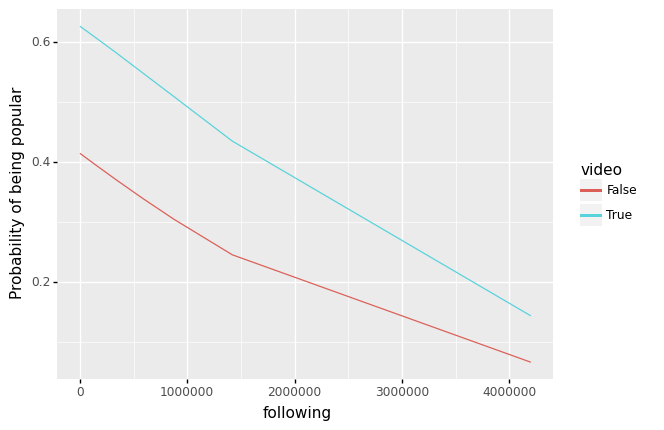

In [19]:
train['video'] = train.video.astype(bool)

graph = (
    pn.ggplot(train, pn.aes(x='following', y='predictions_1', color='video'))
    + pn.geom_line()
    + pn.ylab('Probability of being popular')
)

graph.draw();

Asi apreciamos mucho mejor como afectan nuestras 2 variables. Obviamente esto seria más dificil con más variables pero por ahora nos sirve bien.

Ahora - como podemos evaluar la calidad de las predicciones? Vamos a utilizar metricas tipicas de clasificacion sobre las predicciones - tanto en el train como en el test.

In [20]:
test['predictions_1'] = log_model.predict(sm.add_constant(test[X_variables]))

In [24]:
auc_train = sklearn.metrics.roc_auc_score(train[target], train['predictions_1'])
auc_test = sklearn.metrics.roc_auc_score(test[target], test['predictions_1'])

acc_train = sklearn.metrics.accuracy_score(train[target], train['predictions_1'].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test['predictions_1'].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')

The auc in train is 0.642 and in test it is 0.63, the accuracies are 59.6% and 59.6%


In [25]:
(sklearn.metrics.confusion_matrix(test[target], test['predictions_1'].round()) / test.shape[0]).round(2) * 100

array([[46.,  8.],
       [32., 14.]])

## Mejorando el modelo
Vamos a ver que cosas sencillas podemos hacer para mejorar nuestro modelo - desde usar nuevas variables hasta optimizando el modelo.

In [26]:
train['video'] = train.video.astype(int)

In [27]:
# Probamos cambiar la variable
X_variables = ['followers', 'video']

log_model = sm.Logit(train[target], sm.add_constant(train[X_variables]))
log_model = log_model.fit()

train['predictions_2'] = log_model.predict(sm.add_constant(train[X_variables]))
test['predictions_2'] = log_model.predict(sm.add_constant(test[X_variables]))

print(log_model.summary())

auc_train = sklearn.metrics.roc_auc_score(train[target], train['predictions_2'])
auc_test = sklearn.metrics.roc_auc_score(test[target], test['predictions_2'])

acc_train = sklearn.metrics.accuracy_score(train[target], train['predictions_2'].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test['predictions_2'].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')

Optimization terminated successfully.
         Current function value: 0.618219
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_popular   No. Observations:                28406
Model:                          Logit   Df Residuals:                    28403
Method:                           MLE   Df Model:                            2
Date:                Sat, 16 Oct 2021   Pseudo R-squ.:                  0.1042
Time:                        16:09:18   Log-Likelihood:                -17561.
converged:                       True   LL-Null:                       -19604.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9748      0.019    -51.400      0.000      -1.012      -0.938
followers   6.779e-08   1.51e

In [28]:
train['verified'] = train.verified.astype(int)
train['retweet'] = train.retweet.astype(int)

test['verified'] = test.verified.astype(int)
test['retweet'] = test.retweet.astype(int)

In [30]:
# Probamos con mas variables ya que tiene buena pinta!
X_variables = [
    'followers', 'following', 'video', 'tweets', 'likes', 'media'
]

log_model = sm.Logit(train[target], sm.add_constant(train[X_variables]))
log_model = log_model.fit()

train['predictions_3'] = log_model.predict(sm.add_constant(train[X_variables]))
test['predictions_3'] = log_model.predict(sm.add_constant(test[X_variables]))

print(log_model.summary())

auc_train = sklearn.metrics.roc_auc_score(train[target], train['predictions_3'])
auc_test = sklearn.metrics.roc_auc_score(test[target], test['predictions_3'])

acc_train = sklearn.metrics.accuracy_score(train[target], train['predictions_3'].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test['predictions_3'].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')

Optimization terminated successfully.
         Current function value: 0.607681
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_popular   No. Observations:                28406
Model:                          Logit   Df Residuals:                    28399
Method:                           MLE   Df Model:                            6
Date:                Sat, 16 Oct 2021   Pseudo R-squ.:                  0.1195
Time:                        16:14:03   Log-Likelihood:                -17262.
converged:                       True   LL-Null:                       -19604.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7340      0.024    -30.854      0.000      -0.781      -0.687
followers   6.876e-08    1.6e

### Creando nuevas variables

In [31]:
# Tiene hashtags?
train['has_hashtags'] = (train.hashtags.str.len() > 2).astype(int)

# Es en ingles
train['is_english'] = (train.language == 'en').astype(int)

# Media de likes etc. para sus posts del pasado
train['avg_likes'] = train.likes / train.tweets
train['followers_per_tweet'] = train.followers / train.tweets

# Es un reply?
train['is_reply'] = (train.reply_to.str.len() > 2).astype(int)

In [32]:
potential_variables = [
    'has_hashtags', 'is_english', 'avg_likes', 'followers_per_tweet', 'is_reply'
]

for variable in potential_variables:
    print(f'For variable {variable}:')
    print(train.groupby(target)[variable].agg(['mean', 'sem']))
    print('\n')

For variable has_hashtags:
                mean       sem
is_popular                    
0           0.129378  0.002713
1           0.135094  0.002986


For variable is_english:
                mean       sem
is_popular                    
0           0.768231  0.003411
1           0.724775  0.003902


For variable avg_likes:
                mean       sem
is_popular                    
0           0.313166  0.009141
1           0.197461  0.006216


For variable followers_per_tweet:
                  mean        sem
is_popular                       
0           154.246816   8.671468
1           394.015048  13.538256


For variable is_reply:
                mean       sem
is_popular                    
0           0.144211  0.002840
1           0.045642  0.001823




In [33]:
# Tiene hashtags?
test['has_hashtags'] = (test.hashtags.str.len() > 2).astype(int)

# Es en ingles
test['is_english'] = (test.language == 'en').astype(int)

# Media de likes etc. para sus posts del pasado
test['avg_likes'] = test.likes / test.tweets
test['followers_per_tweet'] = test.followers / test.tweets

# Es un reply?
test['is_reply'] = (test.reply_to.str.len() > 2).astype(int)

In [34]:
# Probamos con mas variables ya que tiene buena pinta!
X_variables = [
    'followers', 'following', 'video', 'retweet', 'tweets', 'likes', 'media', 'verified', 
    'has_hashtags', 'is_english', 'avg_likes', 'followers_per_tweet', 'is_reply'
]

log_model = sm.Logit(train[target], sm.add_constant(train[X_variables]))
log_model = log_model.fit()

train['predictions_4'] = log_model.predict(sm.add_constant(train[X_variables]))
test['predictions_4'] = log_model.predict(sm.add_constant(test[X_variables]))

print(log_model.summary())

auc_train = sklearn.metrics.roc_auc_score(train[target], train['predictions_4'])
auc_test = sklearn.metrics.roc_auc_score(test[target], test['predictions_4'])

acc_train = sklearn.metrics.accuracy_score(train[target], train['predictions_4'].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test['predictions_4'].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')

Optimization terminated successfully.
         Current function value: 0.435133
         Iterations 27
                           Logit Regression Results                           
Dep. Variable:             is_popular   No. Observations:                28406
Model:                          Logit   Df Residuals:                    28392
Method:                           MLE   Df Model:                           13
Date:                Sat, 16 Oct 2021   Pseudo R-squ.:                  0.3695
Time:                        16:16:45   Log-Likelihood:                -12360.
converged:                       True   LL-Null:                       -19604.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.0818      0.098     10.998      0.000       0.889       1.275
f

Con los modelos lineales, las variables suelen ser la mejor fuente de mejoras. Statsmodels tiene una manera de entrenar el modelo que utiliza una "formula" - un concepto inventado en R que puede facilitar la declaración del modelo y "interacciones" entre variables.

In [35]:
import statsmodels.formula.api as smf

In [36]:
formula = f'{target} ~ followers * video'

log_model = smf.logit(formula=formula, data=train)
log_model = log_model.fit()

train['predictions_5'] = log_model.predict(train)
test['predictions_5'] = log_model.predict(test)

print(log_model.summary())

auc_train = sklearn.metrics.roc_auc_score(train[target], train['predictions_5'])
auc_test = sklearn.metrics.roc_auc_score(test[target], test['predictions_5'])

acc_train = sklearn.metrics.accuracy_score(train[target], train['predictions_5'].round())
acc_test = sklearn.metrics.accuracy_score(test[target], test['predictions_5'].round())

print(f'The auc in train is {auc_train:.3} and in test it is {auc_test:.3}, the accuracies are {acc_train:.1%} and {acc_test:.1%}')

Optimization terminated successfully.
         Current function value: 0.617856
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             is_popular   No. Observations:                28406
Model:                          Logit   Df Residuals:                    28402
Method:                           MLE   Df Model:                            3
Date:                Sat, 16 Oct 2021   Pseudo R-squ.:                  0.1047
Time:                        16:19:03   Log-Likelihood:                -17551.
converged:                       True   LL-Null:                       -19604.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.9518      0.020    -48.707      0.000      -0.990      -0.914
followers     

Y hemos conseguido una mejora muy ligera. Ahora no parece tan útil, pero es bueno saber esta tecnica porque los modelos lineales no son capaces de realmente "combinar" variables como algunos más complejos.

### La curva de precision recall
La curva de precision recall es fundamental para entender los resultados y como se podrian aplicar a una problema real de negocio. Lo dibujamos utilizando scikit-learn.

In [37]:
results = []
renames = {0 : 'recall', 1 : 'precision', 2 : 'threshold'}
for i in range(1, 6):
    result = pd.DataFrame(sklearn.metrics.precision_recall_curve(test[target], test[f'predictions_{i}'])).transpose().rename(columns=renames)
    result['prediction_number'] = str(i)
    results.append(result)
    
results = pd.concat(results) 

results['threshold'] = results.threshold.round(3)

results = results.groupby(['prediction_number', 'threshold']).head(1)

results['recall_diff'] = results.groupby('prediction_number').recall.diff()
results['precision_diff'] = results.groupby('prediction_number').precision.diff()

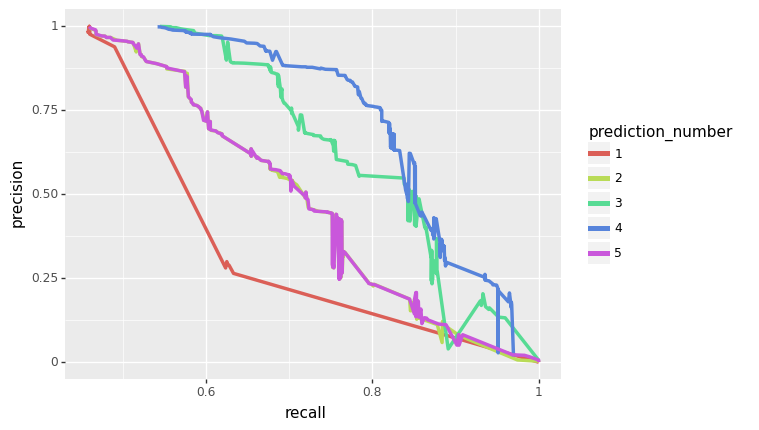

In [78]:
c = (results.recall_diff >= 0)
graph = (
    pn.ggplot(results[c], pn.aes(x='recall', y='precision', color='prediction_number'))
    + pn.geom_line(size=1.4)
)

graph.draw();